Shortened workbench for analysing the sinuosity of stream channels from shapefiles

In [161]:
from sinuutils import readshapestopandas

riverid = 3 # id of channel being analysed (CM_riverid)
#channelname = 'sinuosity_shapefiles/sin_CM5_no2012.shp'
channelname = 'sinuosity_shapefiles/sin_CM%d.shp' % riverid # define channel to be analysed
yearrivers = readshapestopandas(channelname)
# in yearrivers shapeid from readshapestopandas is the year that the profile was drawn


In [162]:
# import shapefile which contains the valley slopes for different years

valleyslope = 'sinuosity_shapefiles/valley_slope_prof_wgs84.shp'

direct_profiles = readshapestopandas(valleyslope)

# in this shapefile, the 'shapeid' is not a year but the id of the channel
# call the correct channel id using riverid

direct_profile = None
for shapeid, d in direct_profiles:
    if shapeid == riverid:
        direct_profile = d

# direct_profile  # uncomment out to see dataset

Text(0, 0.5, 'y position [m]')

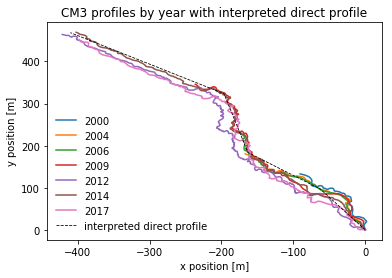

In [163]:
%matplotlib inline 
from matplotlib import pyplot as plt

for year, df in yearrivers:
    plt.plot(df.x, df.y, label='%d' % year)
    
plt.plot(direct_profile.x, direct_profile.y, color='k',linestyle='--',linewidth=0.8, label='interpreted direct profile')
#plt.axis('equal')
plt.legend(loc='lower left',frameon=False)  
plt.title('CM%d profiles by year with interpreted direct profile' % riverid)
plt.xlabel('x position [m]')
plt.ylabel('y position [m]')

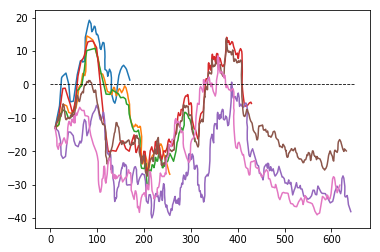

In [164]:
from sinuutils import transaxis
from sinuutils import warptodirect
import numpy as np
    
for year, df in yearrivers:
    straightenedx, straightenedy, cwtx, cwty, r0,r1 = warptodirect(direct_profile, df)
    plt.plot(straightenedx, straightenedy, label="%d" % year)
    
transax = np.linspace(0,r1,10)
transay = np.zeros((10,), dtype=int)
    
plt.plot(transax, transay, color='k', linestyle='--', linewidth=0.8)
#plt.legend(loc='lower left')


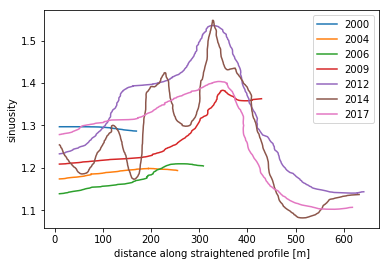

In [165]:
# calculate windowed sinuosity of the river channel
from sinuutils import windowed_sinuosity

# calculate windowed sinuosity for each given year
for year, df in yearrivers:
    wxs, awsin = windowed_sinuosity(df)
    plt.plot(df.straightenedx,df.windowedsin, label='%d' %year)
    
plt.xlabel('distance along straightened profile [m]')
plt.ylabel('sinuosity')
plt.legend()

In [166]:
#yearrivers # uncomment to see full dataframe

start resampled work here

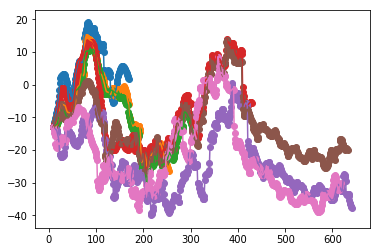

In [167]:
# resample so that distance along reach consistent in the channel profiles
from sinuutils import metre_interp
import pandas as pd

yearrivers_interp = [ ]
for year, df in yearrivers:
    xvals, yinterp = metre_interp(df.straightenedx, df.straightenedy)
    df2 = pd.DataFrame({"chan_xvals":xvals, "chan_yinterp":yinterp})
    vx2 = (df2.chan_xvals - df2.chan_xvals.shift()).fillna(0)
    vy2 = (df2.chan_yinterp - df2.chan_yinterp.shift()).fillna(0)
    df2["straightenedsegleng"] = np.sqrt(vx2**2 + vy2**2)
    yearrivers_interp.append((year, df2))
     
    #plt.plot(df.straightenedx, df.straightenedy, label="%d" % year)
for year, df2 in yearrivers_interp:
    plt.plot(df2.chan_xvals, df2.chan_yinterp)
    plt.scatter(df2.chan_xvals, df2.chan_yinterp) 

In [168]:
#yearrivers_interp # uncomment to see full dataframe

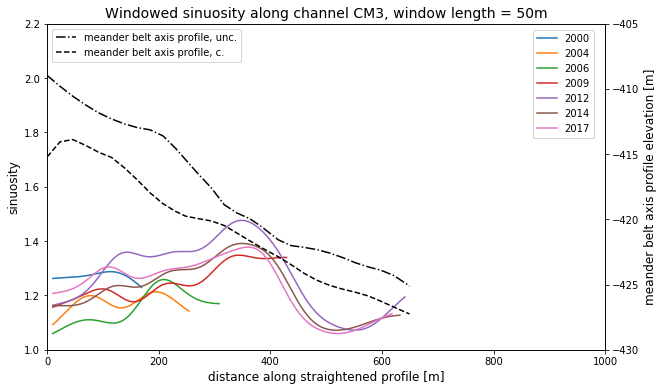

In [169]:
# calculate windowed sinuosity of the river channel
#from sinuutils import makeweightseries

from sinuutils import windowed_sin_interp
centreweightlength = 50 # width of window in metres: change as appropriate

fig = plt.figure(figsize = (10,6))
ax1 = plt.axes()

for year, df2 in yearrivers_interp:
    wxs, awsin = windowed_sin_interp(df2, centreweightlength)
    ax1.plot(df2.chan_xvals,df2.windowedsin, label='%d' %year)

plt.xlim(0, 1000)
plt.ylim(1, 2.2)
plt.xlabel('distance along straightened profile [m]', fontsize=12)
plt.ylabel('sinuosity', fontsize=12)
plt.title('Windowed sinuosity along channel CM%d, window length = %dm' %(riverid,centreweightlength), fontsize=14)

# read in meander belt axes profiles and plot on right hand axes

# dataframe for meander belt axis slopes
df3 = pd.read_csv('../channel_slope_profs/corrected_bath_meander_belt_axes.csv', header=0)

ax2 = ax1.twinx()

for n in range(riverid,riverid+1):
    MBA = df3[df3.prof_id == n]
    ax2.plot(MBA.cds2d, MBA.bathymetry, 'k-.', label='meander belt axis profile, unc.')
    ax2.plot(MBA.cds2d, MBA.bathymetry_new, 'k--', label='meander belt axis profile, c.')

plt.xlim(0, 1000)
plt.ylim(-430, -405)
ax2.set_ylabel('meander belt axis profile elevation [m]', color='k', fontsize=12)
ax2.tick_params('y', colors='k')
ax1.legend(loc=[0.87, 0.65],fontsize=10)
ax2.legend(loc = 'upper left', fontsize=10)

plt.savefig('sinuosity_CM%d_bath_corr.png' %riverid)
plt.savefig('sinuosity_CM%d_bath_corr.svg' %riverid)

need to test out sensitivity of channel sinuosity to different window lengths

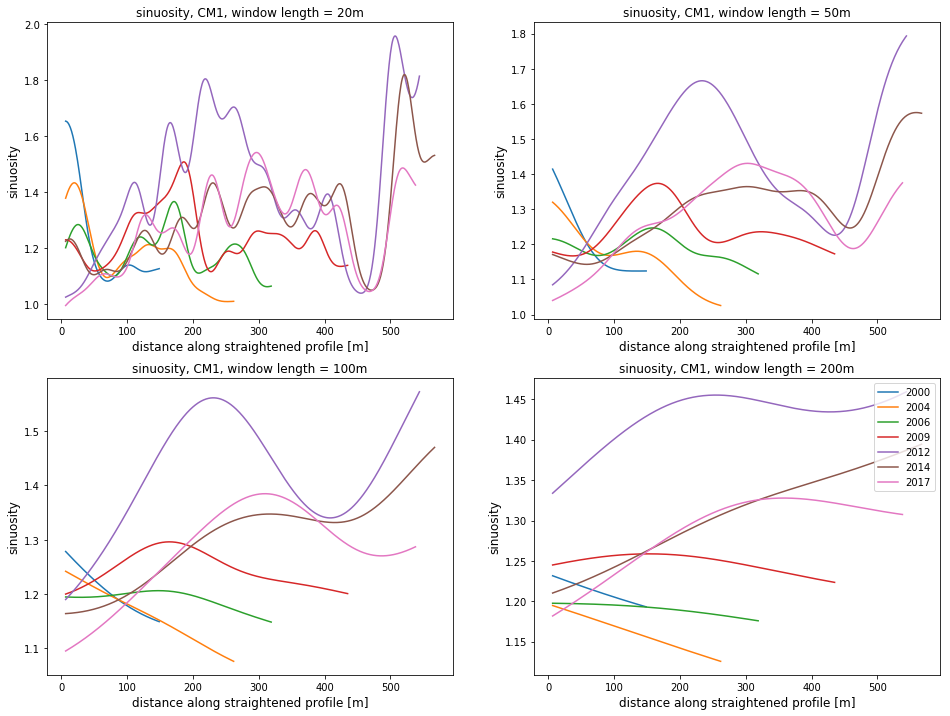

In [160]:
# plot channel sinuosity along length with different window lengths 

fig = plt.figure(figsize = (16,12))

window_tests = [20,50,100,200]

for n in range(0,4):
    ax = fig.add_subplot(2, 2, n+1)
    for year, df2 in yearrivers_interp:
        wxs, awsin = windowed_sin_interp(df2, window_tests[n])
        plt.plot(df2.chan_xvals,df2.windowedsin, label='%d' %year)
        plt.title('sinuosity, CM%d, window length = %dm' %(riverid, window_tests[n]))
        plt.xlabel('distance along straightened profile [m]', fontsize=12)
        plt.ylabel('sinuosity', fontsize=12)

plt.legend(loc = 'upper right')
plt.savefig('windows_CM%d.png' %riverid)

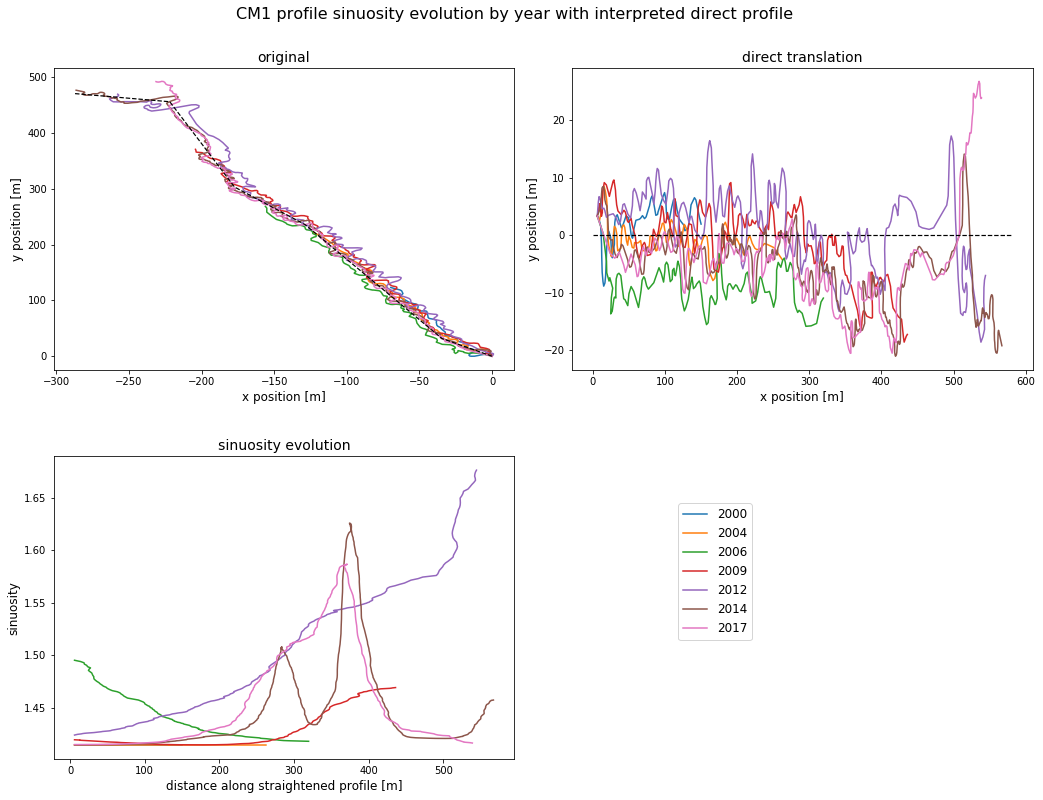

In [9]:
# plot all diagrams for channel so far in one figure and save the figure

# set up color map so that each  line is always plotted with the same colors

import matplotlib.cm as cmx # import color maps
import numpy as np

start = 0.0
stop = 1.0
number_of_lines= 7
cm_subsection = np.linspace(start, stop, number_of_lines) 

colors = [cmx.jet(x) for x in cm_subsection]


#fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
fig = plt.figure(figsize=(16,12))
fig.suptitle('CM%d profile sinuosity evolution by year with interpreted direct profile' % riverid, x=0.5, y=0.97, fontsize=16)

ax1 = fig.add_axes([0.1, 0.55, 0.4, 0.35])
for year, df in yearrivers:
    p_yrs = ax1.plot(df.x, df.y, label='%d' % year)

fig.legend(loc=[0.65, 0.2],fontsize=12)    

ax1.plot(direct_profile.x, direct_profile.y, color='k',linestyle='--', linewidth=1.2)
#plt.legend(loc='lower left',frameon=False)  
#plt.title('CM%d profiles by year with interpreted direct profile' % riverid)
plt.xlabel('x position [m]',fontsize=12)
plt.ylabel('y position [m]',fontsize=12)
plt.title('original',fontsize=14)

ax2 = fig.add_axes([0.55, 0.55, 0.4, 0.35])

for year, df in yearrivers:
    ax2.plot(df.straightenedx, df.straightenedy)
ax2.plot(transax, transay, color='k', linestyle='--', linewidth=1.2)
plt.xlabel('x position [m]',fontsize=12)
plt.ylabel('y position [m]',fontsize=12)
plt.title('direct translation',fontsize=14)

ax3 = fig.add_axes([0.1, 0.1, 0.4, 0.35])

for year, df in yearrivers:
    ax3.plot(df.straightenedx,df.windowedsin)
      
plt.xlabel('distance along straightened profile [m]',fontsize=12)
plt.ylabel('sinuosity',fontsize=12)
plt.title('sinuosity evolution',fontsize=14)

plt.savefig('sin_evo_CM%d.png' % riverid)





In [75]:
# trying to make a color map so that every time I run the script for a different channel the 
# colors plotted are always the same for each year. tried to index as the year and then call 
# this later didn't work


%matplotlib inline
from matplotlib import cm # import color maps
from numpy import linspace
from numpy import array
from pandas import DataFrame

ln_cm = [ ]

start = 0.0
stop = 1.0
number_of_lines = 7
cm_subsection = linspace(start, stop, number_of_lines) 

colors = [ cm.jet(x) for x in cm_subsection ]
cm_yrs = [2000, 2004, 2006, 2009, 2012, 2014, 2017]

ln_cm =DataFrame({"color":colors}, index=cm_yrs)
print(ln_cm)
ln_cm.loc[2000]

                                                  color
2000                               (0.0, 0.0, 0.5, 1.0)
2004                (0.0, 0.1588235294117647, 1.0, 1.0)
2006                (0.0, 0.8333333333333334, 1.0, 1.0)
2009  (0.4901960784313725, 1.0, 0.4775458570524984, ...
2012                (1.0, 0.9012345679012348, 0.0, 1.0)
2014               (1.0, 0.27668845315904156, 0.0, 1.0)
2017                               (0.5, 0.0, 0.0, 1.0)


color    (0.0, 0.0, 0.5, 1.0)
Name: 2000, dtype: object

next step: plot heatmap of sinuosity with distance along channel (x axis) vs time (y axis)

In [52]:
# create a new dataframe storing sinuosity values for the channel according to year (rows) and 
# distance along the channel (columns)

import pandas as pd

reformed_df = [ ]
reformed_dfpivot = [ ]

for year, df in yearrivers:
    dftwo = pd.DataFrame({"xpos":df.straightenedx, "year":year, "sinuosity":df.windowedsin})
    reformed_df.append(dftwo)
    #dftwopivot = df_two.pivot(index='year', columns='xpos', values='sinuosity')
    #reformed_dfpivot.append(dftwopivot)


    



In [53]:
#df_two.pivot(index='year', columns='xpos', values='sinuosity')

In [54]:
# create heatmap of sinuosity with time along length of a given channel using seaborn

import seaborn as sns

# use pivot to revisualise dataset
sin_length_year = reformed_df.pivot(index='year', columns='xpos', values='sinuosity')

# set up the plot
fig, ax = plt.subplots(figsize=(10, 25))
sns.heatmap(reformed_df, cmap='RdYlGr', ax=ax)

AttributeError: 'list' object has no attribute 'pivot'

In [55]:
sin_length_year = df_two.pivot(index='year', columns='xpos', values='sinuosity')

ValueError: Index contains duplicate entries, cannot reshape

In [33]:
sin_length_year

xpos,6.729163507506086,24.585006547763882,29.269869682667643,32.11355715980002,35.55863694519482,38.518911363596686,39.91857262682771,44.193650999093485,48.58002844887904,48.92273022622772,...,90.2278904747375,91.76899723884755,92.28129505150766,93.44952097590176,94.84812461161927,95.86666798814377,96.89728128894177,98.00679580444944,100.59366117342695,102.3297521279719
year,,,,,,,,,,,,,,,,,,,,,
2009,1.479492,1.480476,1.481468,1.482468,1.483476,1.484491,1.485513,1.486542,1.487578,1.48862,...,1.525304,1.52632,1.527327,1.528322,1.529306,1.530278,1.531237,1.532183,1.533115,1.534033
